In [1]:
# Imports and utilities

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

def show_image(image, title=None):
    channels = image.shape[2] if len(image.shape) == 3 else 1
    if channels == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    oldfigsize = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (image.shape[1]//100+1,image.shape[0]//100+1)
    plt.autoscale(enable=True, axis='both', tight=False)
    plt.axis('off')
    plt.imshow(image, aspect='equal', interpolation='gaussian', cmap='gray' if channels == 1 else None)
    plt.title(title)
    plt.show()
    plt.rcParams["figure.figsize"] = oldfigsize


An exploration of approaches for detecting angle brackets <<< on documents with an MRZ
======================================================================================

The task is to locate on any image the angle brackets <<< that are typically used as empty characters in MRZ.

Starting with an image like this:

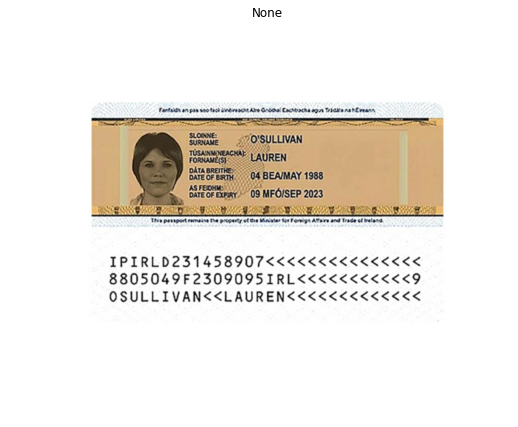

In [2]:
show_image(cv.imread('sample6.jpg'))

It'd be enough if we could just highlight the brackets, so that they look like this:

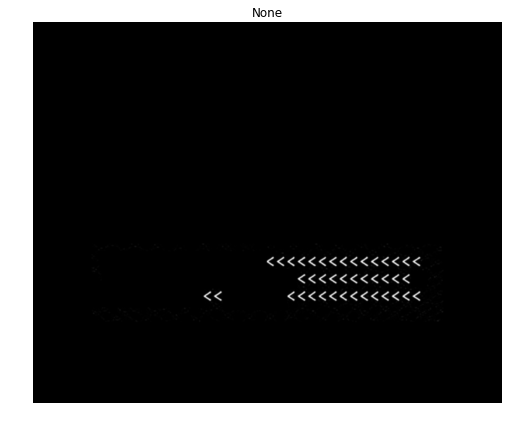

In [3]:
show_image(cv.imread('sample6-highlighted.jpg'))

Then it would be possible to find the actual locations of each character and build bounding boxes around the characters:

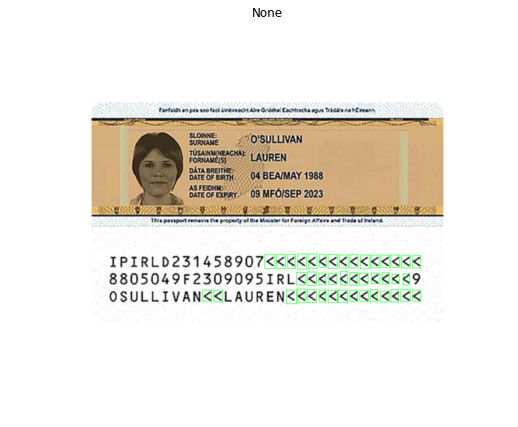

In [4]:
show_image(cv.imread('sample6-outlined.jpg'))

And finally to locate each line of the MRZ in its entirety

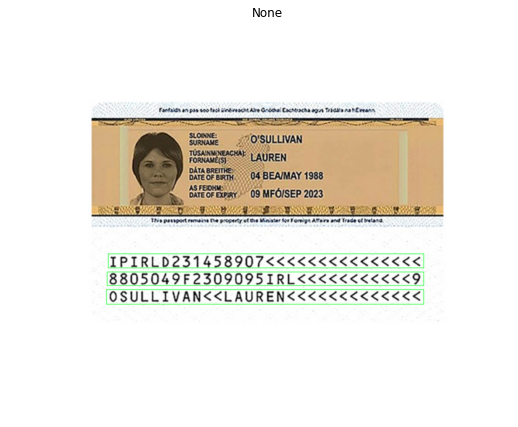

In [5]:
show_image(cv.imread('sample6-mrz.jpg'))

Your mission, should you choose to accept it, is to suggest a program or parts thereof that can get from the first image to the last image for any photo of a travel/identity document that is reasonably well lit and aligned on the image. Basically, any photo with a modern smartphone of a travel document. You might want to use OpenCV's video capture and your computer's webcam as a image source for real-time capture and highlighting, if it helps you with testing and debugging.

For example you might want to try a gradient filter to single out the lines of the brackets. Or you might try contour detection to try and find a contour that looks like an angle bracket. Or you might try template matching. Or you might to straight to a classifier trained on angle brackets. Start with anything that seems reasonable. Fork this repo and develop your solutions in this notebook. Add comments to the code explaining what it is that you're trying to achieve or explore. Push often and report on your progress regularly, say once every day or two.

We'd like to give feedback often and discuss your efforts as they unfold. We'll be glad to help immediately with any stumbling blocks that you might encounter on the way. There's no point in getting stuck in technical details with which we might already have experience. The flow of the task should feel like actual teamwork.

Good luck and have fun!

**NOTE: use your own identity document for testing, but be sure to clear all outputs before committing!**

Here I'm trying to use template matching method. I used grayscale imaging to remove color and light effect from the result. Also, I used matchTemplate function from opencv and 'TM_CCOEFF_NORMED' method for finding similarity.

<img src="method.png">

In [6]:
image = cv.imread('sample6.jpg', cv.IMREAD_GRAYSCALE)
rows, cols = image.shape
template = cv.imread('template.png', cv.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]
method = 'cv.TM_CCOEFF_NORMED'

In [7]:
# Apply template Matching
res = cv.matchTemplate(image, template, eval(method))
# finding the most similar points
lt = np.where(res >= 0.7)
# reshaping them into an array
lts = np.array(list(zip(lt))).squeeze()

Here I'm trying to show the detected results and drawing a boundary around them.

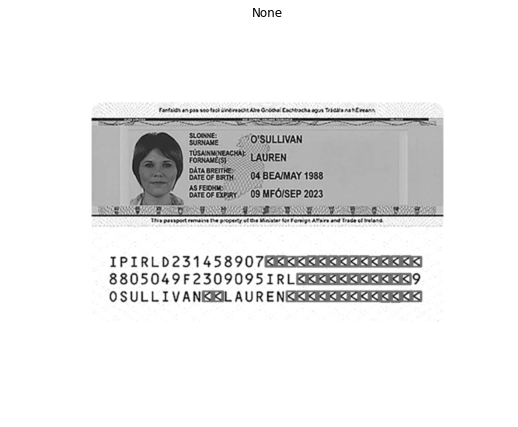

In [8]:
lt_image = np.copy(image)
for i in range(lts.shape[1]):
    cv.rectangle(lt_image, (lts[1, i], lts[0, i]), (lts[1, i] + w, lts[0, i] + h), (110, 255, 255), 2)
show_image(lt_image)

Here I'm calculating the gradient of the image. This would help us to find a better boundary box around the 
desired area.

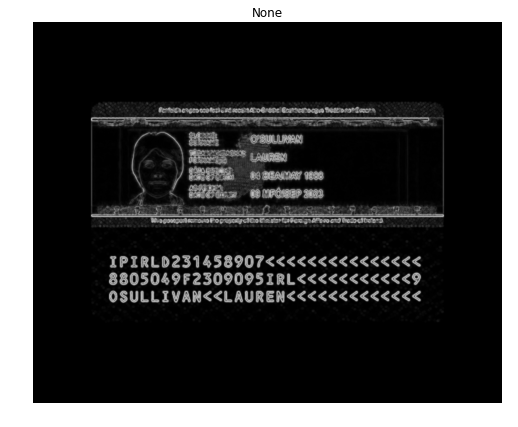

In [9]:
x_gradient = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
y_gradient = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
gradient = np.sqrt(x_gradient ** 2 + y_gradient ** 2)
show_image(gradient)

classes show that how many rows (each row as a different class) we are going to detect and how many bounding boxes we need. I'm using the gradient to shrink the box. min_boxes and max_boxes show the start and end of each bounding box.

In [10]:
classes = np.unique(lts[0, :])
boxes = gradient[classes, :]
min_boxes = []
max_boxes = []
for i in range(boxes.shape[0]):
    box = np.where(boxes[i, :] > 100)
    min_boxes.append(np.min(box))
    max_boxes.append(np.max(box))

We could see the last result in our sample image.

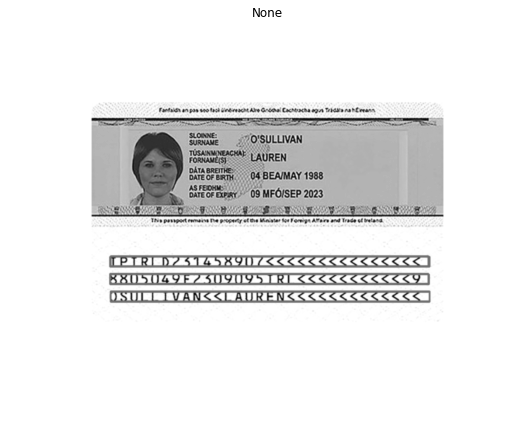

In [11]:
boxes_image = np.copy(image)
for i in range(len(min_boxes)):
    cv.rectangle(boxes_image, (min_boxes[i], classes[i]), (max_boxes[i] + w, classes[i] + h), (110, 255, 255), 2)
show_image(boxes_image)

We know that all of these works are not enough and this would have a multi-scaling problem.
To solve this problem it's just enough to resize the input image and find the best scale.
After finding the best scale we should scale our template accordingly and then find the bounding boxes.
All of these processes are described in the two following functions.
box_finder gets the matching and gives the bounding boxes

In [12]:
def box_finder(image, template, matching, alpha, beta):
    w, h = template.shape[::-1]
    lt = np.where(matching >= alpha)
    lts = np.array(list(zip(lt))).squeeze()
    x_gradient = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    y_gradient = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    gradient = np.sqrt(x_gradient ** 2 + y_gradient ** 2)
    classes = np.unique(lts[0, :])
    boxes = gradient[classes, :]
    min_boxes = []
    max_boxes = []
    for i in range(boxes.shape[0]):
        box = np.where(boxes[i, :] > beta)
        min_boxes.append(np.min(box))
        max_boxes.append(np.max(box))
    boxes_image = np.copy(image)
    for i in range(len(min_boxes)):
        cv.rectangle(boxes_image, (min_boxes[i], classes[i]), (max_boxes[i] + w, classes[i] + h), (110, 255, 255), 2)
    return boxes_image

matching gets the image and finds the best scale for it and then apply the scaling on the template and compute the matching and find the boundary boxes.

In [13]:
def matching(image, template, method, alpha, beta):
    best_match = -1
    best_scale = -1
    for scale in np.linspace(0.5, 2, 20):
        scaled_image = cv.resize(image, (0, 0), fx=scale, fy=scale)
        match = cv.matchTemplate(scaled_image, template, eval(method))
        if np.max(match) > best_match:
            best_match = np.max(match)
            best_scale = scale
    new_template = cv.resize(template, (0, 0), fx=2-best_scale, fy=2-best_scale)
    new_match = cv.matchTemplate(image, new_template, eval(method))
    boxed_image = box_finder(image, new_template, new_match, alpha, beta)
    return boxed_image

Here I tried the functions with my documents. You can also use any document here to see the result.

In [14]:
# image7 = cv.imread('sample7.jpg', cv.IMREAD_GRAYSCALE)
image7 = cv.resize(image, (0, 0), fx=1.5, fy=1.5)

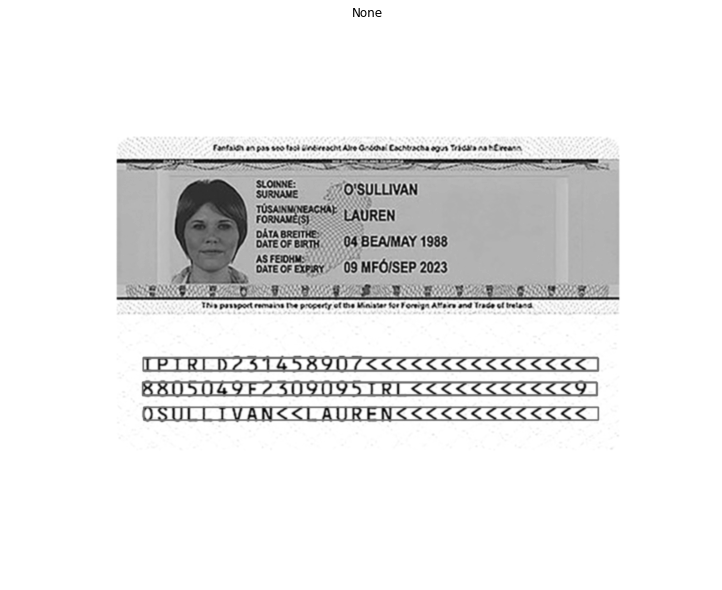

In [15]:
show_image(matching(image7, template, method, 0.9, 100))

Definitely, this is not the best solution for this task. This solution is not rotation invariant and could not work well for the noisy image. The better solution might be using more strong algorithms like HoG, SIFT, ...
Also using neural networks could be a better solution but without having enough data, it is also inefficient.